<center><img src="https://i.imgur.com/HrWLO8e.png"></center>

### Versions:
* Version 7: first baseline model
* Version 8: tuned baseline model (lower score in LB)
* Version 10: added new features - tunned model (lower in LB)
* Version 11: no tunning trial
* Version 13: added standardization, train_test_split and Feature Importance (kept only the important ones)
* Version 15: removed standardization (lower performance) and added stratified=y in `train_test_split` (shuffle=False)
* Version 16: adjusted the `train_data` and `features_data`, as there was a leakage

In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../input/riiid-answer-correctness-prediction-rapids/custom.css", "r").read()
    return HTML("<style>"+styles+"</style>")
css_styling()

# <div class="gradient-box">
# <p>I. Intro: Rapids AI 🏃‍♂️ </p>
# </div>

In [2]:
def notebook_styling():
    styles = open("../input/riiid-answer-correctness-prediction-rapids/custom_rapids.css", "r").read()
    return HTML("<style>"+styles+"</style>")
notebook_styling()

<img src="https://i.imgur.com/QVotmCj.png">

<img src="https://developer.nvidia.com/sites/default/files/pictures/2018/rapids/rapids-logo.png" width=400>

The usually used libraries like `numpy`, `pandas` or `scikit-learn` are designed to work on **CPU**. However, this competition is based on a large amount of data (100+ million rows), so these libraries will perform slowly or, even worse, they won't be able to perform at all. Hence, if you have some **GPUs** at hand (especially here on Kaggle), you can put them to work to help you in this competition :)

Thankfully, the researchers at Nvidia worked hard and in our favor, developing the `RAPIDS` open-source package.

> RAPIDS is an open-source suite of data processing and machine learning libraries developed by NVIDIA that enables GPU-acceleration for data science workflows.

<div class="alert alert-block alert-info">
<b>References I used:</b>
<ul>
    <li><a href = "https://rapids.ai/index.html">RAPIDS - Open GPU Data Science - Official Site</a></li>
    <li><a href = "https://docs.rapids.ai/api/cudf/stable/10min.html#Dask-Performance-Tips">10 mins to CuDF</a></li>
</ul>
</div>

### Libraries 📚

In [3]:
%%time

# Import the Rapids suite here - takes abot 1.5 mins

import sys
!cp ../input/rapids/rapids.0.18.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

CPU times: user 1.59 s, sys: 369 ms, total: 1.96 s
Wall time: 1min 46s


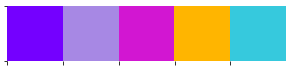

In [4]:
# Regular Libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from IPython.display import display_html
from PIL import Image
import gc
from scipy.stats import pearsonr
import tqdm
import copy
import re

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Color Palette
custom_colors = ['#7400ff', '#a788e4', '#d216d2', '#ffb500', '#36c9dd']
sns.palplot(sns.color_palette(custom_colors))

# Set Style
sns.set_style("whitegrid")
sns.despine(left=True, bottom=True)

# Set tick size
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

*📌Note: Can't use `Dask-cuDF` because we oly have 1 worker and Memory: 13.96 in the Kaggle GPU Accelerator. If we would have had more than 1 worker, `Dask` would have performed even better :)*

In [5]:
# Rapids Imports
import cudf
import cupy # CuPy is an open-source array library accelerated with NVIDIA CUDA.


from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

cluster = LocalCUDACluster()
client = Client(cluster)
client

/opt/conda/envs/rapids/lib/python3.7/site-packages/distributed/client.py:1134: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+---------+
| Package | client | scheduler | workers |
+---------+--------+-----------+---------+
| numpy   | 1.18.5 | 1.18.5    | 1.20.1  |
| tornado | 5.0.2  | 5.0.2     | 6.1     |
+---------+--------+-----------+---------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://127.0.0.1:34647 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 1 Cores: 1 Memory: 13.96 GB


> [Tesla P-100](https://www.nvidia.com/en-us/data-center/tesla-p100/)

In [6]:
!nvidia-smi

Sat Apr 10 14:59:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    35W / 250W |    508MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## CPU vs GPU comparison

> code source is from RAPIDS demo notebooks: Random Forest Demo

In [7]:
# Imports
import cudf
import numpy as np
import pandas as pd
import pickle

from cuml.ensemble import RandomForestClassifier as curfc
from cuml.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier as skrfc
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import time


# Parameters for creating some fake data
n_samples = 2**15
n_features = 399
n_info = 300
data_type = np.float32


# Make Data
X,y = make_classification(n_samples=n_samples,
                          n_features=n_features,
                          n_informative=n_info,
                          random_state=123, n_classes=2)

X = pd.DataFrame(X.astype(data_type))
# cuML Random Forest Classifier requires the labels to be integers
y = pd.Series(y.astype(np.int32))

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state=0)

# From CPU to GPU
X_cudf_train = cudf.DataFrame.from_pandas(X_train)
X_cudf_test = cudf.DataFrame.from_pandas(X_test)

y_cudf_train = cudf.Series(y_train.values)

print("X shape: ", X.shape, "\n" +
      "y shape: ", y.shape)

X shape:  (32768, 399) 
y shape:  (32768,)


### Sklearn (CPU)

In [8]:
print("==== CPU ====", "\n")
# ==== Fit ====

start = time.time()
sk_model = skrfc(n_estimators=40,
                 max_depth=16,
                 max_features=1.0,
                 random_state=10)

sk_model.fit(X_train, y_train)
end = time.time()

print("Training time: {} mins".format(round((end-start)/60, 1)))

# ==== Evaluate ====
start = time.time()
sk_predict = sk_model.predict(X_test)
sk_acc = accuracy_score(y_test, sk_predict)
end = time.time()

print("Evaluation time: {} mins".format(round((end-start)/60, 1)))

==== CPU ==== 

Training time: 5.9 mins
Evaluation time: 0.0 mins


### CuML (GPU)

In [9]:
print("==== GPU ====", "\n")
# ==== Fit ====

start = time.time()
cuml_model = curfc(n_estimators=40,
                   max_depth=16,
                   max_features=1.0,
                   random_state=10,
                   n_streams=1) # for reproducibility

cuml_model.fit(X_cudf_train, y_cudf_train)
end = time.time()

print("Training time: {} mins".format(round((end-start)/60, 1)))

# ==== Evaluate ====
start = time.time()
fil_preds_orig = cuml_model.predict(X_cudf_test)

fil_acc_orig = accuracy_score(y_test.to_numpy(), fil_preds_orig)
end = time.time()

print("Evaluation time: {} mins".format(round((end-start)/60, 1)))

==== GPU ==== 

Training time: 0.2 mins
Evaluation time: 0.1 mins


<div class="alert alert-block alert-success">
<p>In this experiment, CuML is net superior (MUCH faster) than Sklearn - almost 6 minutes vs 30 seconds.</p>
</div>

<img src="https://i.imgur.com/NvHmO3L.png">

<div class="alert alert-block alert-info">
In this section we'll use the <code>cudf</code> and <code>cupy</code> libraries provided by RAPIDS, combined with <code>numpy</code> for the plotting part. The notebook runs at the moment in 3 minutes.
</div>

# 1. train.csv

* `row_id`: (int64) ID code for the row.
* `timestamp`: (int64) the time in milliseconds between this user interaction and the first event completion from that user.
* `user_id`: (int32) ID code for the user.
* `content_id`: (int16) ID code for the user interaction
* `content_type_id`: (bool) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
* `task_container_id`: (int16) ID code for the *batch of questions or lectures*. (eg. a user might see three questions in a row before seeing the explanations for any of them - those three would all share a task_container_id)
* `user_answer`: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
* `answered_correctly`: (int8) if the user responded correctly. Read -1 as null, for lectures.
* `prior_question_elapsed_time`: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between (is null for a user's first question bundle or lecture)
* `prior_question_had_explanation`: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

In [10]:
%%time

# Read in data
dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32", 
    "prior_question_had_explanation": "int8"
}

train = cudf.read_csv('../input/riiid-test-answer-prediction/train.csv', dtype=dtypes)

# # Drop "row_id" column as it doesn't give any information
# train = train.drop(columns = ["row_id"], axis=1, inplace=True)

CPU times: user 3.21 s, sys: 2.35 s, total: 5.56 s
Wall time: 1min 3s


> 📌Note: The only 2 columns with missing data (explained in documentation - `NULL` values are present for the first question bundle)

In [11]:
# Data Information
print("Rows: {:,}".format(len(train)), "\n" +
      "Columns: {}".format(len(train.columns)))

# Find Missing Data if any
total = len(train)

for column in train.columns:
    if train[column].isna().sum() != 0:
        print("{} has: {:,} ({:.2}%) missing values.".format(column, train[column].isna().sum(), 
                                                             (train[column].isna().sum()/total)*100))
        
        
# Fill in missing values with "-1"
train["prior_question_elapsed_time"] = train["prior_question_elapsed_time"].fillna(-1)
train["prior_question_had_explanation"] = train["prior_question_had_explanation"].fillna(-1)

train.head()

Rows: 101,230,332 
Columns: 10
prior_question_elapsed_time has: 2,351,538 (2.3%) missing values.
prior_question_had_explanation has: 392,506 (0.39%) missing values.


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,-1.0,-1
1,1,56943,115,5716,False,2,2,1,37000.0,0
2,2,118363,115,128,False,0,0,1,55000.0,0
3,3,131167,115,7860,False,3,0,1,19000.0,0
4,4,137965,115,7922,False,4,1,1,11000.0,0


## 1.1 Columns individual analysis

* numerical features (distplot): `timestamp`, `prior_question_elapsed_time`
* categorical features (distplot): `user_id` count, `content_id` count, `task_container_id` count
* categorical features (barplot): `user_answer` count, `answered_correctly` count, `prior_question_had_explanation` count

### Predefined functions📂

Because there is no possibility (yet) to use Rapids for visualization we need to preprocess and convert the data to numpy arrays and plot it afterwards.

In [12]:
def distplot_features(df, feature, title, color = custom_colors[4], categorical=True):
    '''Takes a column from the GPU dataframe and plots the distribution (after count).'''
    
    if categorical:
        values = cupy.asnumpy(df[feature].value_counts().values)
    else:
        values = cupy.asnumpy(df[feature].values)
        
    print('Mean: {:,}'.format(np.mean(values)), "\n"
          'Median: {:,}'.format(np.median(values)), "\n"
          'Max: {:,}'.format(np.max(values)))

    
    plt.figure(figsize = (18, 3))
    
    if categorical:
        sns.distplot(values, hist=False, color = color, kde_kws = {'lw':3})
    else:
        # To speed up the process
        sns.distplot(values[::250000], hist=False, color = color, kde_kws = {'lw':3})
    
    plt.title(title, fontsize=15)
    plt.show();
    
    del values
    gc.collect()

In [13]:
def barplot_features(df, feature, title, palette = custom_colors[2:]):
    '''Takes the numerical columns (with less than 10 categories) and plots the barplot.'''
    
    # We need to extract both the name of the category and the no. of appearences
    index = cupy.asnumpy(df[feature].value_counts().reset_index()["index"].values)
    values = cupy.asnumpy(df[feature].value_counts().reset_index()[feature].values) 

    plt.figure(figsize = (18, 3))
    sns.barplot(x = index, y = values, palette = palette)
    plt.title(title, fontsize=15)
    plt.show();
    
    del index, values
    gc.collect()

### Inspect numerical features

Mean: 7,703,643,654.326523 
Median: 2,674,233,764.5 
Max: 87,425,772,049


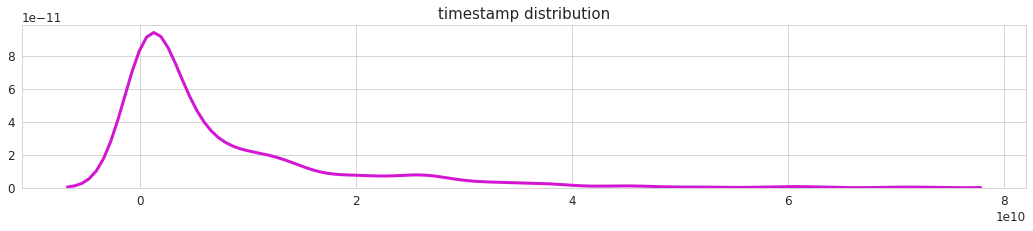

Mean: 24,833.234375 
Median: 21,000.0 
Max: 300,000.0


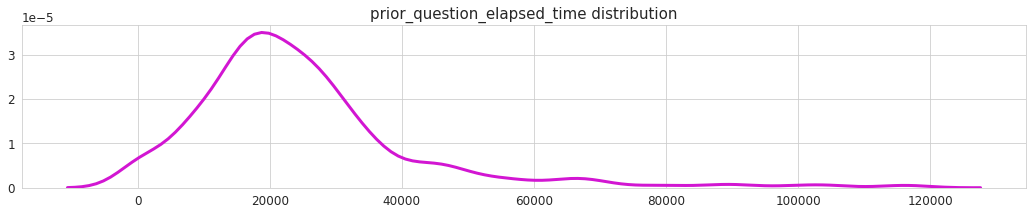

In [14]:
numerical_features = ['timestamp', 'prior_question_elapsed_time']

for feature in numerical_features:
    distplot_features(train, feature=feature, title = feature + " distribution", color = custom_colors[2], categorical=False)

### Inspect Categorical Features: many values

Mean: 257.1542971528441 
Median: 41.0 
Max: 17,917


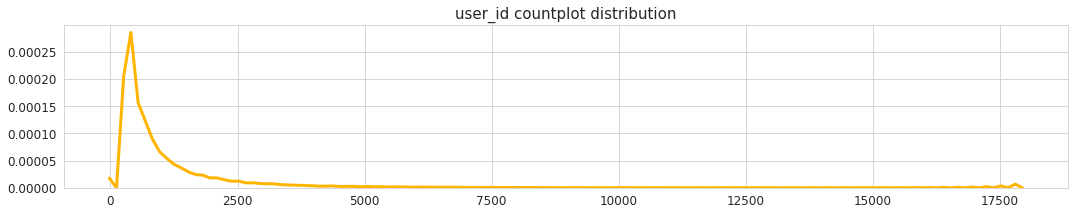

Mean: 7,345.111885067479 
Median: 4,728.5 
Max: 213,605


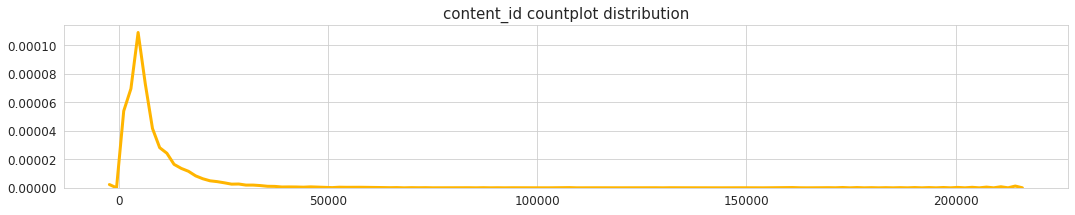

Mean: 10,123.0332 
Median: 1,318.0 
Max: 804,285


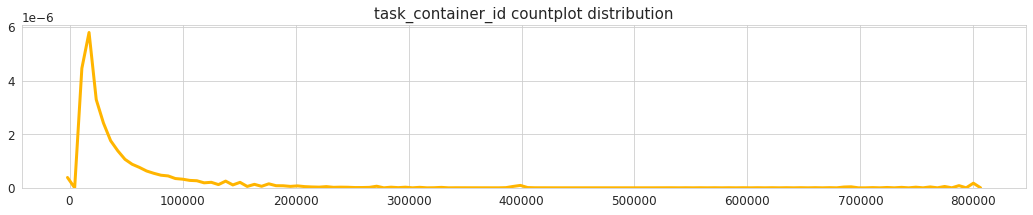

In [15]:
categorical_features = ['user_id', 'content_id', 'task_container_id']

for feature in categorical_features:
    distplot_features(train, feature=feature, title = feature + " countplot distribution", color = custom_colors[3], categorical=True)

### Inspect Categorical Features: fiew values

> There are only a fiew cases where content_type_id is = 1 (meaning lectures) - which is good, we're not supposed to predict those anyways.

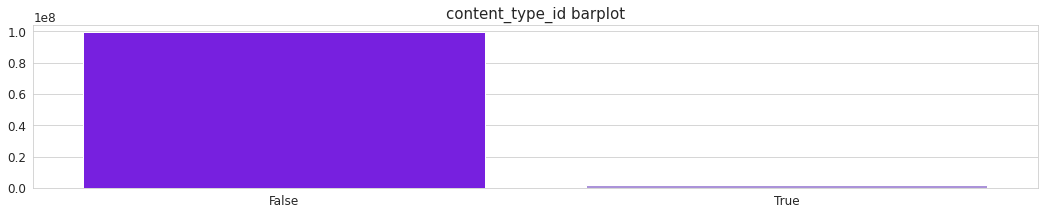

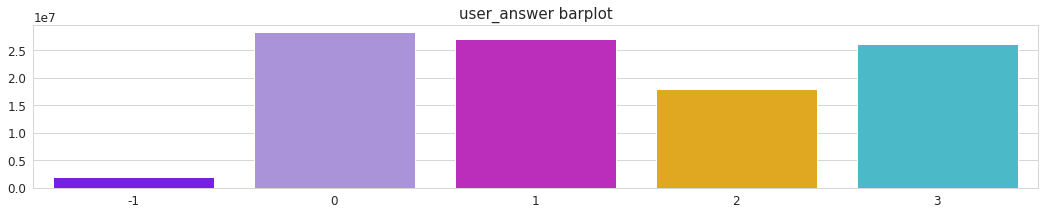

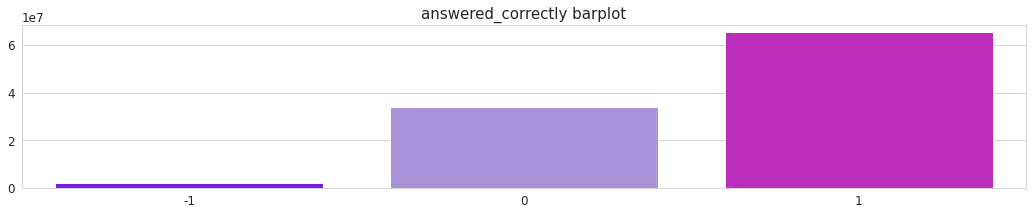

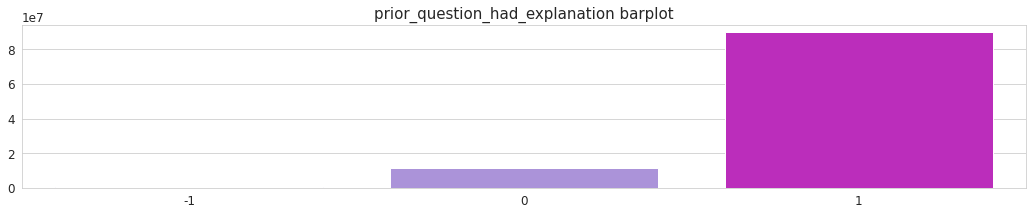

In [16]:
categorical_for_bar = ['content_type_id', 'user_answer', 
                       'answered_correctly', 'prior_question_had_explanation']

for feature in categorical_for_bar:
    barplot_features(train, feature=feature, title = feature + " barplot", palette = custom_colors)

## 1.2 Handle Outliers

> 📌Note: The **outliers** might strongly influence the future models. Hence, we need to carefully handle them. However, by trying to erase the outliers we can erase up to 10% of the data, which is valuable information for training our models.

Eg.: Below we find the upper boundry for the outliers for the feature `timestamp`. This value is equal to 26,138,936,852 milliseconds, which means 7,700 hours, which means about 320 days.

In [17]:
# Total rows we started with
total = len(train)
feature = "timestamp"

# Compute Outliers
Q1 = cupy.percentile(train[feature].values, q = 25).item()
Q3 = cupy.percentile(train[feature].values, q = 75).item()
IQR = Q3 - Q1

# We'll look only at the upper interval outliers
outlier_boundry = Q3 + 1.5*IQR

print('Timestamp: around {:.2}% of the data would be erased.'.format(len(train[train[feature] >= outlier_boundry])/total * 100), 
      "\n"+
      'The outlier boundry is {:,}, which means {:,.5} hrs, which means {:,.5} days.'.format(outlier_boundry, (outlier_boundry / 3.6e+6),
                                                                                       (outlier_boundry / 3.6e+6)/24))

gc.collect()

Timestamp: around 9.4% of the data would be erased. 
The outlier boundry is 24,024,861,068.375, which means 6,673.6 hrs, which means 278.07 days.


0

> 📌Note: However, I would erase all pupils (`user_id`) that have less than 5 appearences in the data (no prediction can be made on these students)  

In [18]:
# Select ids to erase
ids_to_erase = train["user_id"].value_counts().reset_index()[train["user_id"].value_counts().reset_index()["user_id"] < 5]\
                                                                                                                ["index"].values

# Erase the ids
new_train = train[~train['user_id'].isin(ids_to_erase)]

print("We erased {} rows meaning {:.3}% of all data.".format(len(train)-len(new_train), (1 - len(new_train)/len(train))*100))
del ids_to_erase

We erased 599 rows meaning 0.000592% of all data.


## 1.3 Curiosities

First I would like to see if the number of appearences of 1 ID (1 pupil) corresponds to their overall performance (other words, if you assess 1 student multiple times, will they perform better?)

In [19]:
# Count how many times the user answered correctly out of all available times
user_performance = train.groupby("user_id").agg({ 'row_id': ['count'], 'answered_correctly': ['sum'] }).reset_index()
user_performance.columns = ["user_id", "total_count", "correct_count"]
user_performance["performance"] = user_performance["correct_count"] / user_performance["total_count"]

# Create intervals for number of appearences
# between 0 and 1000, 1000 and 2500 and 2500+
def condition(x):
    if x <= 1000:
        return 0
    elif (x > 1000) & (x <= 2500):
        return 1
    else:
        return 2
    
user_performance["total_interval"] = user_performance["total_count"].applymap(condition)

> 📌Note: So yes, the *average* performance increases along with the number of times one student appears in the data.

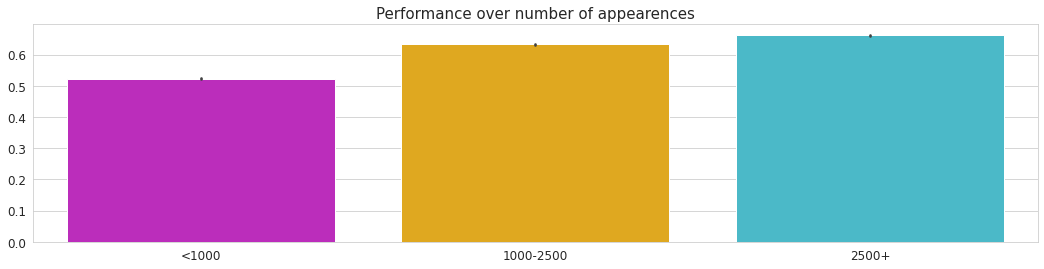

In [20]:
# Convert to numpy arrays (so we can plot)
x = cupy.asnumpy(user_performance["total_interval"].values)
y = cupy.asnumpy(user_performance["performance"].values)

# Plot
plt.figure(figsize = (18, 4))
sns.barplot(x = x, y = y, palette = custom_colors[2:])
plt.title("Performance over number of appearences", fontsize = 15)
plt.xticks([0, 1, 2], ['<1000', '1000-2500', '2500+']);

del user_performance

## 1.4 Save and delete

> To keep the notebook as light as possible and to not overload the memory, we save the `train` data in .feather format (lighter, takes about 7 seconds to upload using `cudf`) and delete the dataframes.

*UPDATE: even better - as Chris Deotte recommends: "Instead of using .feather use .parquet. RAPIDS cuDF can read parquet 6x faster than feather (and writes parquet 1.1x faster)"*

In [21]:
# First cleanup
del train
gc.collect()


# Checkpoint: save to .parquet
new_train.to_parquet('new_train.parquet')

In [22]:
# Clean the environment
del new_train
gc.collect()

44

# 2. questions.csv

* `question_id`: foreign key for the train/test `content_id` column, when the content type is question (0).
* `bundle_id`: code for which questions are served together.
* `correct_answer`: the answer to the question. Can be compared with the train user_answer column to check if the user was right.
* `part`: the relevant section of the TOEIC test.
* `tags`: one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

> The Test of English for International Communication (TOEIC) is an international standardized test of English language proficiency for non-native speakers.

In [23]:
questions = cudf.read_csv('../input/riiid-test-answer-prediction/questions.csv')

# Data Information
print("Rows: {:,}".format(len(questions)), "\n" +
      "Columns: {}".format(len(questions.columns)))

# Find Missing Data if any
total = len(questions)

for column in questions.columns:
    if questions[column].isna().sum() != 0:
        print("{} has: {:,} ({:.2}%) missing values.".format(column, questions[column].isna().sum(), 
                                                             (questions[column].isna().sum()/total)*100))
        
        
# Fill in missing values with "-1"
questions["tags"] = questions["tags"].fillna(-1)

questions.head()

Rows: 13,523 
Columns: 5
tags has: 1 (0.0074%) missing values.


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


## 2.1 Inspect the columns

* categorical features (distplot): `question_id` count, `bundle_id` count, `tags` count
* categorical features (barplot): `correct_answer`, `part`

In [24]:
# ----- question_id -----

# The table contains an equal number of IDs for each question
print('There is a total of {:,} IDs.'.format(len(questions['question_id'].value_counts())), "\n")

# ----- bundle_id -----
print('There are {:,} unique bundle IDs.'.format(questions['bundle_id'].nunique()))

There is a total of 13,523 IDs. 

There are 9,765 unique bundle IDs.


> 📌Note: majority of the questions are from part 5 - if this distribution doesn't match the `test` set, there might be some issues :)

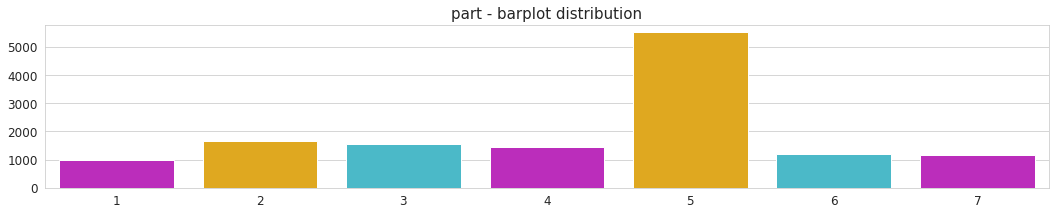

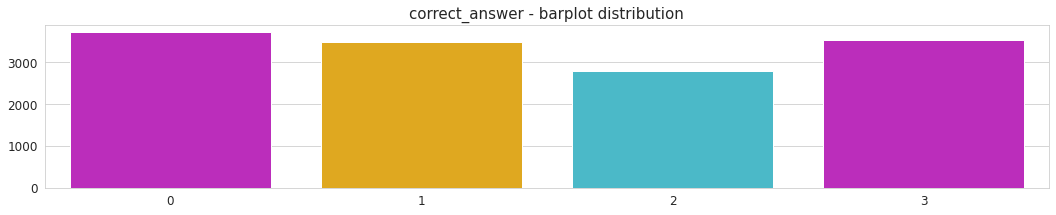

In [25]:
# ----- part & correct_answer -----

for feature in ['part', 'correct_answer']:
    barplot_features(questions, feature=feature, title=feature + " - barplot distribution")

Mean: 8.89671052631579 
Median: 2.0 
Max: 738


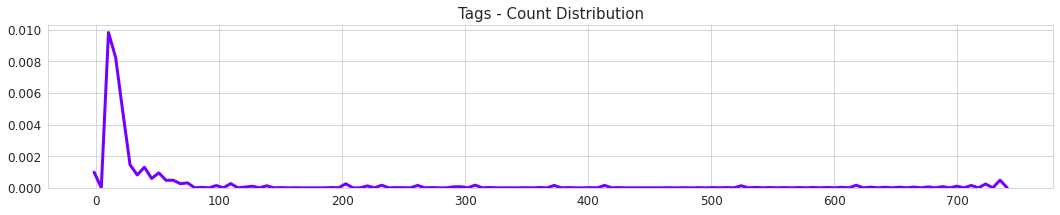

In [26]:
# ----- tags -----
distplot_features(questions, 'tags', title = "Tags - Count Distribution", color = custom_colors[0], categorical=True)

## 2.2 Save and delete

In [27]:
# Checkpoint: save to parquet
questions.to_parquet('questions.parquet')

In [28]:
del questions
gc.collect()

40

# 3. lectures.csv

* `lecture_id`: foreign key for the train/test `content_id` column, when the content type is lecture (1).
* `part`: top level category code for the lecture.
* `tag`: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
* `type_of`: brief description of the core purpose of the lecture (`string` - so this data needs to be treated a bit different)

*no missing values*

In [29]:
lectures = cudf.read_csv('../input/riiid-test-answer-prediction/lectures.csv')

# Encode 'type_of' column
lectures.type_of,codes = lectures['type_of'].factorize()

# Data Information
print("Rows: {:,}".format(len(lectures)), "\n" +
      "Columns: {}".format(len(lectures.columns)))
lectures.head()

Rows: 418 
Columns: 4


,lecture_id,tag,part,type_of
0,89,159,5,0
1,100,70,1,0
2,185,45,6,0
3,192,79,5,2
4,317,156,5,2


## 3.1 Inspect the columns

In [30]:
# ----- lecture_id -----
# The table contains an equal number of IDs for each question
print('There is a total of {:,} IDs.'.format(len(lectures['lecture_id'].value_counts())), "\n")

# There are 151 unique tags
print('There are a total of {:,} unique tags IDs.'.format(len(lectures['tag'].value_counts())))

There is a total of 418 IDs. 

There are a total of 151 unique tags IDs.


## 3.2 Save and delete

In [31]:
lectures.to_parquet("lectures.parquet")

del lectures
gc.collect()

40

<img src="https://i.imgur.com/3cBHzEF.png">

> Let's look again at the structure of our data:
<img src="https://i.imgur.com/gjuzFkl.png" width=550>

<div class="alert alert-block alert-success">
<p><b>This section uses the <code>cuML</code> package and XGBoost to compute the predictions.</b></p>
</div>

In [32]:
cudf.set_allocator("managed")

In [33]:
%%time
# Import the data
train = cudf.read_parquet("../input/riiid-answer-correctness-prediction-rapids/new_train.parquet")
questions = cudf.read_parquet("../input/riiid-answer-correctness-prediction-rapids/questions.parquet")

# Lectures we won't load, as we are not supposed to predict for these rows

CPU times: user 1.79 s, sys: 950 ms, total: 2.74 s
Wall time: 30.1 s


In [34]:
%%time
# Let's exclude all observations where (content_type_id = 1) & (answered_correctly = -1)
train = train[train['content_type_id'] != 1]
train = train[train['answered_correctly'] != -1].reset_index(drop=True)

CPU times: user 1.74 s, sys: 559 ms, total: 2.3 s
Wall time: 2.26 s


# 1. Feature Engineering

In [35]:
# Parameters
train_percent = 0.1
total_len = len(train)

In [36]:
# Split data into train data & feature engineering data (to use for past performance)
# Timestamp is in descending order - meaning that the last 10% observations have
# the biggest chance of having had some performance recorded before
# so looking at the performance in the past we'll try to predict the performance now

features_df = train.iloc[ : int(total_len*(1-train_percent))]
train_df = train.iloc[int(total_len*(1-train_percent)) : ]

## 1.1 Feature Engineering - Create Data

In [37]:
%%time
# --- STUDENT ANSWERS ---
# Group by student
user_answers = features_df[features_df['answered_correctly']!=-1].\
                            groupby('user_id').\
                            agg({'answered_correctly': ['sum', 'mean', 'min', 
                                                        'max', 'count', 'median', 
                                                        'std', 'var']}).\
                            reset_index()

user_answers.columns = ['user_id', 'user_sum', 'user_mean', 'user_min', 'user_max', 
                        'user_count', 'user_median', 'user_std', 'user_var']


# --- CONTENT ID ANSWERS ---
# Group by content
content_answers = features_df[features_df['answered_correctly']!=-1].\
                            groupby('content_id').\
                            agg({'answered_correctly': ['sum', 'mean', 'min', 
                                                        'max', 'count', 'median', 
                                                        'std', 'var']}).\
                            reset_index()

content_answers.columns = ['content_id', 'content_sum', 'content_mean', 'content_min', 
                           'content_max', 'content_count', 'content_median', 'content_std', 
                           'content_var']

CPU times: user 3.57 s, sys: 726 ms, total: 4.3 s
Wall time: 4.23 s


> Save FE data; we will use it for the `test` set too :)

In [38]:
user_answers.to_parquet('user_answers.parquet')
content_answers.to_parquet('content_answers.parquet')

In [39]:
del train, questions
gc.collect()

64

## 1.2 Predefined Functions for Preprocesing¶

> Combine new features with the `train_df`

In [40]:
from sklearn.preprocessing import StandardScaler

In [41]:
# Features for ML
features_to_keep = ['user_sum', 'user_mean', 'user_min', 'user_max', 
                        'user_count', 'user_median', 'user_std', 'user_var',
                   'content_sum', 'content_mean', 'content_min', 
                           'content_max', 'content_count', 'content_median', 'content_std', 
                           'content_var']
target = 'answered_correctly'

all_features = features_to_keep.copy()
all_features.append(target)


# We need to convert True-False variables to integers
def to_bool(x):
    '''For the string variables.'''
    if x == False:
        return 0
    else:
        return 1

    
def combine_features(data = None):
    '''Combine the features with the Train/Test data.'''
    
    # Add "past" information
    features_data = data.merge(user_answers, how = 'left', on = 'user_id')
    features_data = features_data.merge(content_answers, how = 'left', on = 'content_id')

    # Apply
    features_data['content_type_id'] = features_data['content_type_id'].applymap(to_bool)
    features_data['prior_question_had_explanation'] = features_data['prior_question_had_explanation'].applymap(to_bool)

    # Fill in missing spots
    features_data.fillna(value = -1, inplace = True)
    
    return features_data


# Scaling the data did not perform as I expected to - so for now we will exclude it
def scale_data(features_data=None, train=True, features_to_keep=None, target=None):
    '''Scales the provided data - if the data is for training, excludes the target column.
    It also chooses the features used in the prediction.'''
    
    data_for_standardization = features_data[features_to_keep]
    matrix = data_for_standardization.as_matrix()
    scaled_matrix = StandardScaler().fit_transform(matrix)
    
    scaled_data = cudf.DataFrame(scaled_matrix)
    scaled_data.columns = data_for_standardization.columns
    
    # We don't want to scale the target also
    if train:
        scaled_data[target] = features_data[target]
        
    return scaled_data

## 1.3 Apply Functions - getting data ready

In [42]:
%%time

train_df = combine_features(data=train_df)
# train_df = scale_data(features_data=train_df, train=True, features_to_keep=features_to_keep, target=target)

# Comment this if you're scaling
train_df = train_df[all_features]

print("Observations in train: {:,}".format(len(train_df)))
train_df.head()

Observations in train: 9,927,071
CPU times: user 7.4 s, sys: 242 ms, total: 7.64 s
Wall time: 7.47 s


,user_sum,user_mean,user_min,user_max,user_count,user_median,user_std,user_var,content_sum,content_mean,content_min,content_max,content_count,content_median,content_std,content_var,answered_correctly
0,-1,-1.0,-1,-1,-1,-1.0,-1.0,-1.0,2452,0.724800,0,1,3383,1.0,0.446681,0.199524,1
1,-1,-1.0,-1,-1,-1,-1.0,-1.0,-1.0,12123,0.647320,0,1,18728,1.0,0.477817,0.228309,0
2,-1,-1.0,-1,-1,-1,-1.0,-1.0,-1.0,8458,0.542423,0,1,15593,1.0,0.498213,0.248216,1
3,-1,-1.0,-1,-1,-1,-1.0,-1.0,-1.0,13461,0.651707,0,1,20655,1.0,0.476441,0.226996,0
4,-1,-1.0,-1,-1,-1,-1.0,-1.0,-1.0,11492,0.743626,0,1,15454,1.0,0.436645,0.190659,1


# 2. XGBoost Model

> The [Stratified K Fold](https://nbviewer.jupyter.org/github/daxiongshu/notebooks-extended/blob/kdd_plasticc/competition_notebooks/kaggle/landmark/cudf_stratifiedKfold_1000x_speedup.ipynb) function using `cudf` is from Grandmaster [Jiwei Liu](https://www.kaggle.com/jiweiliu)

In [43]:
# RAPIDS roc_auc_score is 16x faster than sklearn. - cdeotte
from cuml.metrics import roc_auc_score
from cuml.preprocessing.model_selection import train_test_split
import xgboost
import pickle

In [44]:
# Features, target and train/test split
X = train_df[features_to_keep]
y = train_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    shuffle=False, stratify=y)

## 2.1 Baseline Model

### Helper Function that runs multiple models

In [45]:
def train_xgb_model(X_train, X_test, y_train, y_test, params, details="default", prints=True):
    '''Trains an XGB and returns the trained model + ROC value.'''
    # Create DMatrix - is optimized for both memory efficiency and training speed.
    train_matrix = xgboost.DMatrix(data = X_train, label = y_train)
    
    # Create & Train the model
    model = xgboost.train(params, dtrain = train_matrix)

    # Make prediction
    predicts = model.predict(xgboost.DMatrix(X_test))
    roc = roc_auc_score(y_test.astype('int32'), predicts)

    if prints:
        print(details + " - ROC: {:.5}".format(roc))
    
    return model, roc


def param_tuning_graph(param_values, roc_values):
    '''Represents visually the ROC results for the speciffic parameter tune.'''
    
    plt.figure(figsize=(18, 3))
    ax = sns.barplot(x=param_values, y=roc_values, palette=custom_colors)

    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height:.5%}', (x + width/2, y + height*1.02), ha='center')

In [46]:
%%time

params1 = {
    'max_depth' : 4,
    'max_leaves' : 2**4,
    'tree_method' : 'gpu_hist',
    'objective' : 'reg:logistic',
    'grow_policy' : 'lossguide'
}

model1, roc1 = train_xgb_model(X_train, X_test, y_train, y_test, 
                               params1, details="baseline model")

baseline model - ROC: 0.71624
CPU times: user 7.06 s, sys: 843 ms, total: 7.9 s
Wall time: 8.53 s


<div class="alert alert-block alert-info">
<p><b>We have a ROC score of 0.71623 in ~14 seconds.</b></p>
<p>Incredible.</p>
</div>

In [47]:
# save model to file
pickle.dump(model1, open("xgb_baseline.pickle.dat", "wb"))

## 2.2 Fine Tuning

> Let's see if we can improve the ROC by only tuning the hyperparameters.

In [48]:
%%time

# --- ETA ---
# aka learning rate

rocs2 = []
etas2 = [0.001, 0.005, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

for eta in etas2:
    params2 = {
        'max_depth' : 4,
        'max_leaves' : 2**4,
        'tree_method' : 'gpu_hist',
        'objective' : 'reg:logistic',
        'grow_policy' : 'lossguide',
        'eta' : eta
    }
    
    _, roc = train_xgb_model(X_train, X_test, y_train, y_test, 
                             params2, details = f"ETA: {eta}")
    rocs2.append(roc)
    
    
# Optional: Further tunning
max_depths = [4, 5, 6, 7, 8]

ETA: 0.001 - ROC: 0.71514
ETA: 0.005 - ROC: 0.71534
ETA: 0.01 - ROC: 0.71564
ETA: 0.1 - ROC: 0.71623
ETA: 0.2 - ROC: 0.71624
ETA: 0.3 - ROC: 0.71624
ETA: 0.4 - ROC: 0.71622
ETA: 0.5 - ROC: 0.71619
ETA: 0.6 - ROC: 0.71617
CPU times: user 16.4 s, sys: 5.83 s, total: 22.2 s
Wall time: 21.9 s


In [49]:
# # --- SAVE CHECKPOINT ---
# params_final = {
#     'max_depth' : 8,
#     'max_leaves' : 2**4,
#     'tree_method' : 'gpu_hist',
#     'objective' : 'reg:logistic',
#     'grow_policy' : 'lossguide',
#     'eta' : 0.5
# }

# model2, roc2 = train_xgb_model(X_train, X_test, y_train, y_test, 
#                                params_final, prints=None)

# # save model to file
# pickle.dump(model2, open("baseline_model_tuned.pickle.dat", "wb"))

## 2.4 Feature Importance

In [50]:
import shap

explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(X_test.to_pandas())

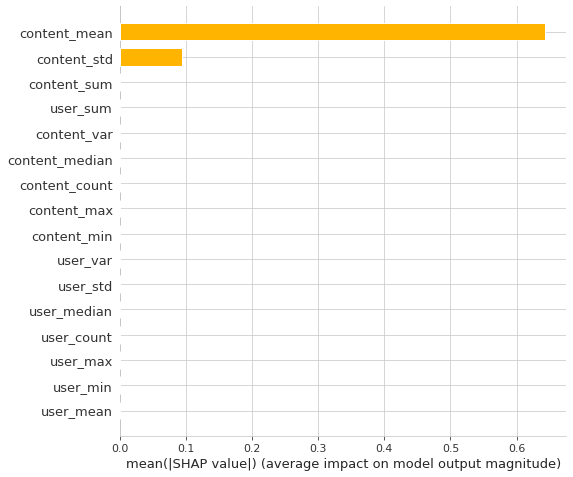

In [51]:
shap.summary_plot(shap_values, X_test.to_pandas(), plot_type="bar", color=custom_colors[3],
                  title = "")

# 3. LightGBM Model

<div class="alert alert-block alert-warning">
<p><b>If you know any resource that shows how you can use a GPU dataframe to work with Stratified Folding and LGBM please comment :) I've been struggling to find some good tutorials and this is the best I could do so far.</b></p>
</div>

In [52]:
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import metrics
import lightgbm as lgbm
from sklearn import metrics
import gc
import pickle

In [53]:
# We'll do a train | validation | test situation
train, test = train_test_split(train_df, test_size=0.3, shuffle=False)

train = train.to_pandas()
test = test.to_pandas()

In [54]:
# -----------
n_splits = 2
# -----------

skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

oof = np.zeros(len(train))
predictions = np.zeros(len(test))

# Covertion to CPU data
skf_split = skf.split(X=train[features_to_keep], y=cupy.asnumpy(train[target].values))

In [55]:
param = {
        'num_leaves': 80,
        'max_bin': 250,
        'min_data_in_leaf': 11,
        'learning_rate': 0.01,
        'min_sum_hessian_in_leaf': 0.00245,
        'bagging_fraction': 1.0, 
        'bagging_freq': 5, 
        'feature_fraction': 0.05,
        'lambda_l1': 4.972,
        'lambda_l2': 2.276,
        'min_gain_to_split': 0.65,
        'max_depth': 14,
        'save_binary': True,
        'seed': 1337,
        'feature_fraction_seed': 1337,
        'bagging_seed': 1337,
        'drop_seed': 1337,
        'data_random_seed': 1337,
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'verbose': 1,
        'metric': 'auc',
        'is_unbalance': True,
        'boost_from_average': False,
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0
    }

In [56]:
%%time

# Training Loop
counter = 1

for train_index, valid_index in skf_split:
    print("==== Fold {} ====".format(counter))
    
    lgbm_train = lgbm.Dataset(data = train.iloc[train_index, :][features_to_keep].values,
                              label = train.iloc[train_index, :][target].values,
                              feature_name = features_to_keep,
                              free_raw_data = False)
    
    lgbm_valid = lgbm.Dataset(data = train.iloc[valid_index, :][features_to_keep].values,
                              label = train.iloc[valid_index, :][target].values,
                              feature_name = features_to_keep,
                              free_raw_data = False)
    
    lgbm_2 = lgbm.train(params = param, train_set = lgbm_train, valid_sets = [lgbm_valid],
                        early_stopping_rounds = 12, num_boost_round=100, verbose_eval=25)
    
    
    # X_valid to predict
    oof[valid_index] = lgbm_2.predict(train.iloc[valid_index][features_to_keep].values, 
                                      num_iteration = lgbm_2.best_iteration)
    predictions += lgbm_2.predict(test[features_to_keep], 
                                  num_iteration = lgbm_2.best_iteration) / n_splits
    
    counter += 1

==== Fold 1 ====
Training until validation scores don't improve for 12 rounds
[25]	valid_0's auc: 0.710773
[50]	valid_0's auc: 0.711472
[75]	valid_0's auc: 0.711829
[100]	valid_0's auc: 0.712038
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.712232
==== Fold 2 ====
Training until validation scores don't improve for 12 rounds
[25]	valid_0's auc: 0.710829
[50]	valid_0's auc: 0.711518
[75]	valid_0's auc: 0.711841
[100]	valid_0's auc: 0.712117
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.7123
CPU times: user 6min 11s, sys: 10.9 s, total: 6min 22s
Wall time: 3min 31s


In [57]:
print("CV ROC: {:<0.2f}".format(metrics.roc_auc_score(test[target], predictions)))

CV ROC: 0.71


In [58]:
# # save model to file
# # the model was initially trained on 10,000 num_boost_round
# # but to keep the notebook running quiqly I modified it in the example to only 100
# pickle.dump(lgbm_2, open("lgbm_10000_12.pickle.dat", "wb"))

<img src="https://i.imgur.com/lrSAmpi.png">

> This competition has the inference a bit different - for reference please check [this notebook.](https://www.kaggle.com/sohier/competition-api-detailed-introduction/comments) Hence, in the `for` loop we create the actual submission (can be seen in the output).

> Training Part: We don't have access to test set labels because we are predicting before getting labels. That's how it is in real world too: You predict today and get the labels tomorrow. You can use tomorrow's labels to predict the day after. And so on. Per day or per batch. - Vopani

Things we'll have to apply to `test` set:
* we assume the `test` set DOESN'T have `content_type_id` = 1 NOR `answered_correctly` = -1
* add information from `user_answers`
* add information from `content_answers`
* change True/False columns to 1/0
* fill missing values with -1
* normalize the features

Bonus: select only the features we want :)

In [59]:
lgbm_2 = pickle.load(open('../input/riiid-answer-correctness-prediction-rapids/lgbm_10000_12.pickle.dat', 'rb'))

In [60]:
# Import library and create environment
import riiideducation
env = riiideducation.make_env()

In [61]:
# Here you would also add your pretrained model
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    test_df = cudf.from_pandas(test_df)
    
    # --- PREPROCESSING ---
    # Here is time to apply the preprocessing to the test_df
    test_df = combine_features(data = test_df)
    #X = scale_data(features_data=test_df, train=False, features_to_keep=features_to_keep).to_pandas()
    X = test_df[features_to_keep].to_pandas()
    
    # --- MODEL ---
    test_df['answered_correctly'] = lgbm_2.predict(X, num_iteration = lgbm_2.best_iteration)
    test_df = test_df.to_pandas()
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])

<img src="https://i.imgur.com/cUQXtS7.png">

# Specs on how I prepped & trained ⌨️🎨
### (*locally*)
* Z8 G4 Workstation 🖥
* 2 CPUs & 96GB Memory 💾
* NVIDIA Quadro RTX 8000 🎮
* RAPIDS version 0.17 🏃🏾‍♀️